In [1729]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import isnan, log
from scipy.stats import linregress
import matplotlib.dates as mdates

In [1730]:
###### remove extraneous data from the CDC Excess Deaths data set and add the mid-point of excess deaths estimate ######

# Import CDC excess deaths data from file
xs_deaths = pd.read_csv("data/xs_deaths.csv")

# The CDC data has three entries for each state for each week. These represent whether they are Type "Predicted(weighted)" or "Unweighted" and Outcome "All causes"
# or "All causes, excluding COVID-19". For this analysis I onlly want the "Predicte(weighted)" and "All causes, excluding COVID-19". 
# Droping Type "All causes" solves that problem
xs_deaths.drop(xs_deaths[(xs_deaths['Outcome'] == 'All causes')].index , inplace=True)

# change the "date" to datetime type
xs_deaths['Week Ending Date'] =  pd.to_datetime(xs_deaths['Week Ending Date'])

#capture the lastest date of the CDC data - used later for getting avg of most recent excess deaths
latest_date_of_cdc_data = xs_deaths['Week Ending Date'].max()

# Drop PR and the "all US" data
indexNames = xs_deaths[ (xs_deaths['State'] == 'Puerto Rico') | 
                        (xs_deaths['State'] == 'United States')].index

xs_deaths.drop(indexNames , inplace=True) 

# Select only values that match the time period for the JHU data
xs_deaths_2020 = xs_deaths[(xs_deaths['Week Ending Date'] > '2020-01-21')].copy()
del xs_deaths

# drop the unnecessary columns 
xs_deaths_2020 = xs_deaths_2020.drop(xs_deaths_2020.columns[[2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16]], axis=1)

# add the average of the upper and lower xs deaths to the df
xs_deaths_2020['mid_point_xs_deaths'] = (xs_deaths_2020['Excess Lower Estimate'] + xs_deaths_2020['Excess Higher Estimate'])/2

# rename columns
xs_deaths_2020.rename(columns={"Week Ending Date": "date", "State":"state"}, inplace=True)

## merge the NYC city with the NY state data (CDC had the data broken out separately) ##
# merge the data
ny_data = xs_deaths_2020.loc[xs_deaths_2020['state'].str.contains('New York')].groupby('date').sum()

# Add a new 'state' column for merging back with the xs_deaths_2020 df
ny_data['state'] = 'New York'
ny_data.reset_index(inplace=True)

# change the order of the columns (probably delete this later)
ny_data = ny_data[['date', 'state', 'Excess Lower Estimate', 'Excess Higher Estimate', 'mid_point_xs_deaths']]

# drop the NY and NYC data from the xs_deaths_2020 df
xs_deaths_2020.drop(xs_deaths_2020[xs_deaths_2020['state'].str.contains('New York')].index , inplace=True)

# concatenate xs_death_2020 and ny_data so the df has all NY (NYC and NY state) data as NY state
dfs_to_concat = [xs_deaths_2020, ny_data]
xs_deaths_2020_ny = pd.concat(dfs_to_concat)
del xs_deaths_2020
del ny_data

# sort the data to be tidy :-)
xs_deaths_2020_ny.sort_values(by=['state','date'], inplace=True)
xs_deaths_2020_ny.reset_index(inplace=True)
del xs_deaths_2020_ny['index']

###### end/remove extraneous data from the CDC Excess Deaths data set ######




###### munge JHU data, remove extraneous data, and add 7-day rolling averages ######

# import data files
new_cases = pd.read_csv("data/jhu_confirmed_daily.csv")
new_deaths = pd.read_csv("data/jhu_deaths_daily.csv")

# drop the following columns because they aren't important to this analysis
new_cases.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Country_Region", "Lat", "Long_", "Combined_Key"], axis=1, inplace=True)
new_deaths.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Country_Region", "Lat", "Long_", "Combined_Key", "Population"], axis=1, inplace=True)

# melt into a long form instead of wide
new_cases_long = new_cases.melt(id_vars=["Admin2", "Province_State"], var_name="Date", value_name="New_Cases")
new_deaths_long = new_deaths.melt(id_vars=["Admin2", "Province_State"], var_name="Date", value_name="Deaths")
del new_cases
del new_deaths

# convert the date column from a string into datetime
new_cases_long['Date'] = pd.to_datetime(new_cases_long['Date'])
new_deaths_long['Date'] = pd.to_datetime(new_deaths_long['Date'])

## JHU data is at the county level - sum all the data from counties into state level ##
# groupby/sum - from https://jamesrledoux.com/code/group-by-aggregate-pandas
# output -> index, Province_State, Date, new_cases
new_cases_by_state = new_cases_long.groupby(['Province_State','Date']).agg({'New_Cases':['sum']})
del new_cases_long
new_cases_by_state.columns = ['new_cases']
new_cases_by_state = new_cases_by_state.reset_index()
new_cases_by_state.sort_values(['Province_State','Date'], inplace=True)

# output -> index, Province_State, Date, new_deaths
new_deaths_by_state = new_deaths_long.groupby(['Province_State','Date']).agg({'Deaths':['sum']})
del new_deaths_long
new_deaths_by_state.columns = ['new_deaths']
new_deaths_by_state = new_deaths_by_state.reset_index()
new_deaths_by_state.sort_values(['Province_State','Date'], inplace=True)

# replacing the administrative corrections that cause an artificial bump in NJ's deaths on 6/25/20
# https://kywnewsradio.radio.com/articles/news/new-jersey-now-reporting-probable-covid-19-deaths

new_deaths_by_state_fixed = new_deaths_by_state.copy()
del new_deaths_by_state

deaths_NJ_6_24 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-24')].values[0]

deaths_NJ_6_25 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-25')].values[0]

deaths_NJ_6_26 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-26')].values[0]

substitution_value = ((deaths_NJ_6_24+deaths_NJ_6_26)/2)

new_deaths_by_state_fixed.loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-25'), 'new_deaths'] = substitution_value

del deaths_NJ_6_26

# add a column of a 7-day rolling average to daily cases and deaths
new_cases_by_state['new_cases_rollavg'] = (new_cases_by_state.groupby('Province_State')
                                                            .rolling(7)['new_cases']
                                                            .mean()
                                                            .reset_index(drop=True))

new_deaths_by_state_fixed['new_deaths_rollavg'] = (new_deaths_by_state_fixed.groupby('Province_State')
                                                                .rolling(7)['new_deaths']
                                                                .mean()
                                                                .reset_index(drop=True))

# Outer Join of the daily_cases and daily_deaths tables
combined_daily_cases_deaths = pd.merge(new_cases_by_state,new_deaths_by_state_fixed,on=['Province_State','Date'],how='outer')
del new_cases_by_state
del new_deaths_by_state_fixed

# drop Diamond Princess, Guam, American Somoa, Northern Mariana Islands, and Puerto Rico (other data sets don't have the territories)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Diamond Princess"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Grand Princess"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "American Samoa"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Guam"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Northern Mariana Islands"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Puerto Rico"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Virgin Islands"].index, inplace=True)

# save the processed data as a csv (for use by other applications such as the Streamlit webapp)
combined_daily_cases_deaths.to_csv("data/daily_cases_deaths.csv", index=False)

###### end/munge JHU data, remove extraneous data, and add 7-day rolling averages ######





###### create a table of the JHU data summed into weekly values instead of daily and merge with CDC excess deaths data ######

# drop the rolling averages, they're not necessary for the weekly sums data
daily_cases_deaths = combined_daily_cases_deaths.drop(combined_daily_cases_deaths.columns[[3, 5]], axis=1)
del combined_daily_cases_deaths

# rename columns because I prefer this convention
daily_cases_deaths.rename(columns={"Province_State": "state", "Date": "date", "new_cases": "new_cases_jhu", "new_deaths":"new_deaths_jhu"}, inplace=True)

# sum the weekly cases, match the week starting date to the one used by the CDC
weekly_cases_deaths = daily_cases_deaths.groupby('state').resample('W-SAT', on='date').sum()
weekly_cases_deaths['new_deaths_jhu'] = weekly_cases_deaths['new_deaths_jhu'].astype(int)

# delete the lastest week if it's not a complete week
latest_date_of_jhu_data = daily_cases_deaths['date'].max()

# reset the index so 'date' is a column
weekly_cases_deaths.reset_index(inplace=True)

if latest_date_of_jhu_data.weekday() != 5:
    latest_date_of_weekly_cases_deaths = weekly_cases_deaths['date'].max()
    weekly_cases_deaths = weekly_cases_deaths[weekly_cases_deaths.date != latest_date_of_weekly_cases_deaths]

# free memory
del daily_cases_deaths

# merge the CDC weekly excess deaths with the JMU deaths data
weekly_cases_deaths_xs = pd.merge(weekly_cases_deaths, xs_deaths_2020_ny, how='left', left_on=['state','date'], right_on=['state','date']) 

###### end/group the JHU data into weekly values instead of daily ######

###### get the average of the last 4 values mid_point_xs_deaths

select_back_to = latest_date_of_cdc_data - timedelta(weeks=4) # this gives the date of the 5th week back

# select only the latest 4 weeks of data from the CDC excess deaths data
latest_weeks_xs_deaths = weekly_cases_deaths_xs[(weekly_cases_deaths_xs['date'] > select_back_to) & 
                                                (weekly_cases_deaths_xs['date'] <= latest_date_of_cdc_data)].copy()

# average the latest 4 weeks data
latest_weeks_xs_deaths_avg = latest_weeks_xs_deaths.groupby('state').mean()

# convert the results to integers (rounds down)
latest_weeks_xs_deaths_avg = latest_weeks_xs_deaths_avg.astype(int)

# add the dates to indicate what date range the averages were taken from
latest_weeks_xs_deaths_avg['data_from_dates_after'] = select_back_to
latest_weeks_xs_deaths_avg['data_from_dates_up_to'] = latest_date_of_cdc_data

# reset the index
latest_weeks_xs_deaths_avg.reset_index(inplace=True)

###### end/get the average of the last 4 values mid_point_xs_deaths ######




###### calculating estimated actual deaths per day from CDC xs deaths and JHU reported deaths data ######

# create a dictionary of the mid_point_xs_deaths to make calculation quicker in the df
state_xs_deaths_dict = latest_weeks_xs_deaths_avg.set_index('state').to_dict()['mid_point_xs_deaths']

# function to calculate the reported + excess deaths - use value if exists for date, otherwise use 
# average of last 4 weeks of reported data

# the old version that didn't work well for states will low deaths
# def est_deaths(row):
#     if row['date'] <= latest_date_of_cdc_data:
#         corrected_value = row.fillna(0)['new_deaths_jhu'] + row.fillna(0)['mid_point_xs_deaths']
#     else:
#         corrected_value = row.fillna(0)['new_deaths_jhu'] + state_xs_deaths_dict[row['state']]
#     return corrected_value

# the new-improved version that doesn't estimate excess deaths for when a state has less than
# 6 deaths that week. Instead, it just uses the JHU reported deaths value and doesn't make a
# correction.
def est_deaths(row):
    if row['new_deaths_jhu'] < 6:
        corrected_value = row.fillna(0)['new_deaths_jhu']
    elif row['date'] <= latest_date_of_cdc_data:
        corrected_value = row.fillna(0)['new_deaths_jhu'] + row.fillna(0)['mid_point_xs_deaths']
    else:
        corrected_value = row.fillna(0)['new_deaths_jhu'] + state_xs_deaths_dict[row['state']]
    return corrected_value

# apply the calculation to each row
weekly_cases_deaths_xs['corr_new_deaths'] = weekly_cases_deaths_xs.apply(est_deaths, axis=1)

# save the data as a csv for the other modules
weekly_cases_deaths_xs.to_csv("data/weekly_cases_deaths_xs.csv", index=False)

###### end/calculating estimated actual deaths per day from CDC xs deaths and JHU reported deaths data ######


###### add the estimated infections that occured 2 weeks previous to the date of the corrected deaths ######

est_infections = weekly_cases_deaths_xs[['state', 'date','corr_new_deaths']].copy()

est_infections['offset_date'] = est_infections['date'] - timedelta(weeks=2)

# this is the inverse of the estimated infection fatality ratio - taken from literature
# https://www.medrxiv.org/content/10.1101/2020.05.03.20089854v4
# https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
estimated_ifr = 1/0.0068

est_infections['est_inf'] = est_infections['corr_new_deaths'] * estimated_ifr
est_infections['est_inf'] = est_infections['est_inf'].astype(int)


# drop estimated infections before the start of the JHU dataset - not critical, just because
est_infections.drop(est_infections[est_infections['offset_date'] < '2020-01-22'].index , inplace=True)

# drop rows that were used to generate data but are not needed in the merge
est_infections.drop(['date', 'corr_new_deaths'], axis = 1, inplace=True) 

# merge the estimate infections back with weekly_cases_deaths_xs. This will result
# in nan values for the lastest two weeks. This method back-calculates the estimated 
# number of infections that had to have occured to cause the specified number of deaths,
# therefore the latest two weeks will have nan values. These values will be filled in 
# as time proceeds.
weekly_est_cases_deaths = weekly_cases_deaths_xs.merge(est_infections, 
                                                       left_on=['state','date'], 
                                                       right_on=['state','offset_date'],
                                                       how='outer')

###### end/add the estimated infections that occured 2 weeks previous to the date of the corrected deaths ######




###### add percent change in weekly est_inf ######

def per_change_est_cases_func(rows):
    # temporarily set panda options so that values with "divide by 0" are converted to nan instead of infinity
    with pd.option_context('mode.use_inf_as_na', True):
        rows['pro_chg_est_inf'] = (rows['est_inf'] - rows['est_inf'].shift(1)) / rows['est_inf'].shift(1)    
        return rows

weekly_est_cases_deaths = weekly_est_cases_deaths.groupby('state').apply(per_change_est_cases_func)
weekly_est_cases_deaths['pro_chg_est_inf'] = weekly_est_cases_deaths['pro_chg_est_inf'].round(4)

###### end/add percent change in weekly est_inf ######


###### calculating the estimated proportion of the population that has already been infected with COVID-19 ######

# remove the last 2 weeks of data for each state because we don't have estimated infections for those dates
max_date_est_inf = weekly_est_cases_deaths['offset_date'].max()
trimed_last_2_wks = weekly_est_cases_deaths[(weekly_est_cases_deaths['date'] <= max_date_est_inf)]

sum_infections = trimed_last_2_wks.groupby('state')['est_inf','new_cases_jhu'].sum().astype('int32')

# add state population data
state_pop = pd.read_csv('data/state_pop.csv')

percent_pop_infected = state_pop.merge(sum_infections, left_on="NAME", right_on="state")
percent_pop_infected['est_proportion_infected'] = (percent_pop_infected['est_inf'] /
                                              percent_pop_infected['POPESTIMATE2019'])
percent_pop_infected['rep_proportion_infected'] = (percent_pop_infected['new_cases_jhu'] /
                                              percent_pop_infected['POPESTIMATE2019'])

percent_pop_infected.sort_values(by=['est_proportion_infected'], ascending=False, inplace=True)
percent_pop_infected.rename(columns={"NAME": "state", "POPESTIMATE2019": "2019_pop", "est_inf":"sum_est_inf", "new_cases_jhu":"sum_new_cases_jhu"}, inplace=True)

total_pop = percent_pop_infected['2019_pop'].sum()
total_infected = percent_pop_infected['sum_est_inf'].sum()
total_reported_infected = percent_pop_infected['sum_new_cases_jhu'].sum()

percent_total_us_pop_est_infected = f"{100*total_infected/total_pop:.1f}"
percent_total_us_pop_reported_infected = f"{100*total_reported_infected/total_pop:.1f}"

# from https://worldpopulationreview.com/states/state-abbreviations
state_abbrevs = pd.read_csv('data/state_abbrevs.csv')

def add_state_id(row):
    state = row['state']
    state_id = state_abbrevs[state_abbrevs['State'] == state]['Code']
    return state_id.values[0]
    
percent_pop_infected['state_id'] =  percent_pop_infected.apply(add_state_id, axis=1)

latest_date_of_estimate = str(max_date_est_inf)[:10]
date_of_reporting = str(latest_date_of_jhu_data)[:10]

# drop the offset date column
del weekly_est_cases_deaths['offset_date']


print(f'Latest date of entry in JHU data {date_of_reporting}\n')
print('Estimated total percent of the US population that')
print(f'has been infected by COVID-19 as of {latest_date_of_estimate}:      '+str(percent_total_us_pop_est_infected)+'%\n')
print('Reported total percent of the US population that')
print(f'has been infected by COVID-19 as of {latest_date_of_estimate}:      '+str(percent_total_us_pop_reported_infected)+'%\n')
print(f'Propotion of population in all states that have been infected as of {latest_date_of_estimate} (reverse rank ordered)')
print('-----------------------------------------------------------------------------------------------------')
percent_pop_infected

###### end/calculating the estimated proportion of the population that has already been infected with COVID-19 ######

Latest date of entry in JHU data 2020-08-24

Estimated total percent of the US population that
has been infected by COVID-19 as of 2020-08-08:      10.5%

Reported total percent of the US population that
has been infected by COVID-19 as of 2020-08-08:      1.5%

Propotion of population in all states that have been infected as of 2020-08-08 (reverse rank ordered)
-----------------------------------------------------------------------------------------------------


,state,2019_pop,sum_est_inf,sum_new_cases_jhu,est_proportion_infected,rep_proportion_infected,state_id
30,New Jersey,8882190,2908667,184429,0.327472,0.020764,NJ
32,New York,19453561,6211679,420345,0.319308,0.021608,NY
6,Connecticut,3565287,756091,50320,0.212070,0.014114,CT
21,Massachusetts,6892503,1404915,120711,0.203832,0.017513,MA
18,Louisiana,4648794,868444,128746,0.186811,0.027694,LA
8,District of Columbia,705749,116536,12653,0.165124,0.017928,DC
24,Mississippi,2976149,488300,66646,0.164071,0.022393,MS
38,Pennsylvania,12801989,1947197,122665,0.152101,0.009582,PA
22,Michigan,9986857,1469917,96191,0.147185,0.009632,MI
39,Rhode Island,1059361,155870,19738,0.147136,0.018632,RI


In [1731]:
###### estimating the population size of people infectious at specific dates ######
# in the original version of this analysis I was calculating total number of infections
# on a daily basis. In this version I switched to calculating infections on a weekly 
# basis to improve the statistical quality of the data. Previously I was calculating the 
# number of people who were in an infectious state by summing all the people infected 
# between 4 and 11 days prior to the day of interest. That won't work with this method
# since I'm summing up infections by week. I could still maintain a count of infections by 
# day but I don't think it would be that much of a change relative to just using the count
# of the people infected in the previous week as the number of people in an infectious 
# state - it should be a good enough approximation for a machine learning approach.


# formula to sum up all the people who were infected between 4-10 days previous to the 
# current date being evaluated (literature estimate of avg infectious period is 7 days)
def infectious_count(row):
    offset_index = row.name - 1
    if row['state'] == weekly_est_cases_deaths.iloc[offset_index,0]:
        if isnan(weekly_est_cases_deaths.iloc[offset_index,9]):
            pass
        else:
            infectious_populace = weekly_est_cases_deaths.iloc[offset_index,8]
            return infectious_populace

weekly_est_cases_deaths["mobile_infectious"] = weekly_est_cases_deaths.apply(infectious_count, axis=1)

def proportion_infected(row):
    state = row['state']
    pop = percent_pop_infected[percent_pop_infected['state'] == state]['2019_pop']
    phi = row['mobile_infectious'] / pop.values[0]
    return phi

def population(row):
    state = row['state']
    pop = percent_pop_infected[percent_pop_infected['state'] == state]['2019_pop']
    return pop.values[0]

# these functions take a while to run because of the recursive iteration
weekly_est_cases_deaths["phi"] = weekly_est_cases_deaths.apply(proportion_infected, axis=1)
weekly_est_cases_deaths["population"] = weekly_est_cases_deaths.apply(population, axis=1)

###### end/estimating the population size of people infectious at specific dates ######

In [1732]:
# something is wrong with the simplemaps data. I found a brand new source that the Census Bureau is publishing for COVID
# https://covid19.census.gov/datasets/average-household-size-and-population-density-county/data?geometry=125.999%2C-0.672%2C-125.368%2C76.524

# column headings
# OBJECTID	 GNIS County Code	 Geographic Identifier - FIPS Code	 Area of Land (square meters)	 Area of Water (square meters)	 Name	 
# State	 Average Household Size	 Average Household Size - Margin of Error	 Average Household Size of Owner-Occupied Unit	 
# Average Household Size of Owner-Occupied Unit - Margin of Error	 Average Household Size of Renter-Occupied Unit	 
# Average Household Size of Renter-Occupied Unit - Margin of Error	 Total Population	 Total Population - Margin of Error	 
# Population Density (people per square kilometer)	 created_user	 created_date	 last_edited_user	 last_edited_date	 Shape__Area	 
# Shape__Length	 Population Density - Margin of Error

fips_density = pd.read_csv('data/Average_Household_Size_and_Population_Density_-_County.csv')
fips_density.head(3)

,FID,COUNTYNS,GEOID,ALAND,AWATER,NAME,State,B25010_001E,B25010_001M,B25010_002E,...,B01001_001E,B01001_001M,B01001_calc_PopDensity,created_user,created_date,last_edited_user,last_edited_date,B01001_calc_PopDensityM,SHAPE_Length,SHAPE_Area
0,1,161526,1001,1539602123,25706961,Autauga County,Alabama,2.59,0.05,2.59,...,55200,NaN,35.853419,esri_demographics,2020/04/01 20:53:36,esri_demographics,2020/04/01 20:53:36,0.0,2.066037,0.150256
1,2,161527,1003,4117546676,1133055836,Baldwin County,Alabama,2.61,0.04,2.66,...,208107,NaN,50.541504,esri_demographics,2020/04/01 20:53:36,esri_demographics,2020/04/01 20:53:36,0.0,4.483746,0.409904
2,3,161528,1005,2292144655,50538698,Barbour County,Alabama,2.49,0.07,2.44,...,25782,NaN,11.247981,esri_demographics,2020/04/01 20:53:36,esri_demographics,2020/04/01 20:53:36,0.0,2.695262,0.223270


In [1733]:
# make a table of each states population
state_pop = fips_density.groupby('State')['B01001_001E'].sum()
state_pop

state_density = fips_density[['State', 'NAME', 'B01001_001E', 'B01001_calc_PopDensity']].copy()
state_density.rename(columns={'State':'state','NAME':'county','B01001_001E':'county_pop', 'B01001_calc_PopDensity':'county_pop_density'}, inplace=True)
state_density.head(3)

,state,county,county_pop,county_pop_density
0,Alabama,Autauga County,55200,35.853419
1,Alabama,Baldwin County,208107,50.541504
2,Alabama,Barbour County,25782,11.247981


In [1734]:
state_pops = state_density.groupby('state')['county_pop'].sum()

In [1735]:
state_density = state_density.merge(state_pops, left_on='state', right_on='state', how='outer') 
state_density.rename(columns={'county_pop_x':'county_pop','county_pop_y':'state_pop'}, inplace=True)

In [1736]:
# pop density is people per square kilometer

state_density['proportional_co_density'] = state_density['county_pop'] / state_density['state_pop'] * state_density['county_pop_density']

In [1737]:
state_density.head(5)

,state,county,county_pop,county_pop_density,state_pop,proportional_co_density
0,Alabama,Autauga County,55200,35.853419,4864680,0.406832
1,Alabama,Baldwin County,208107,50.541504,4864680,2.162124
2,Alabama,Barbour County,25782,11.247981,4864680,0.059612
3,Alabama,Bibb County,22527,13.973114,4864680,0.064706
4,Alabama,Blount County,57645,34.515816,4864680,0.409002


In [1738]:
state_densities = state_density.groupby('state')['proportional_co_density'].sum()
state_densities = pd.DataFrame(data=state_densities)
state_densities.reset_index(inplace=True)
state_densities.rename(columns={'proportional_co_density':'state_density'}, inplace=True)
state_densities.head(5)

,state,state_density
0,Alabama,91.937932
1,Alaska,28.190256
2,Arizona,118.855999
3,Arkansas,66.648161
4,California,709.933780


In [1739]:
def log_density(row):
    state_density = row['state_density']
    log_state_density = log(state_density)
    return log_state_density

state_densities['log_state_density'] = state_densities.apply(log_density, axis=1)

# state_densities['log_state_density'] = state_densities.apply(lambda x: log(state_densities['state_density']))

# state_densities['log_state_density'] = log(state_densities['state_density'])

In [1740]:
state_densities

,state,state_density,log_state_density
0,Alabama,91.937932,4.521114
1,Alaska,28.190256,3.338976
2,Arizona,118.855999,4.777913
3,Arkansas,66.648161,4.199427
4,California,709.933780,6.565172
5,Colorado,349.522827,5.856569
6,Connecticut,435.244606,6.075908
7,Delaware,336.101691,5.817414
8,District of Columbia,4322.952569,8.371694
9,Florida,389.002804,5.963587


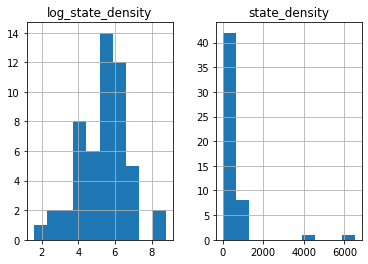

In [1741]:
hist = state_densities.hist()

In [1742]:
state_densities.sort_values(by=['state_density'], inplace=True)

highest_density = state_densities.nlargest(1, 'log_state_density')
highest_density.values[0]

array(['New York', 6525.341291386587, 8.783448536016373], dtype=object)

In [1743]:
# rho is the normalized avg_city_density index between 0 and 1 (1 being set by the most dense state)
state_densities['propotionate_log_density'] = state_densities['log_state_density'] / highest_density.values[0][2]
state_densities.reset_index(drop=True, inplace=True)
state_densities.head(5)

,state,state_density,log_state_density,propotionate_log_density
0,Wyoming,4.784258,1.565331,0.178214
1,Montana,10.657449,2.366259,0.269400
2,North Dakota,16.302211,2.791301,0.317791
3,South Dakota,27.960124,3.330779,0.379211
4,Alaska,28.190256,3.338976,0.380144


In [1744]:
state_densities

,state,state_density,log_state_density,propotionate_log_density
0,Wyoming,4.784258,1.565331,0.178214
1,Montana,10.657449,2.366259,0.269400
2,North Dakota,16.302211,2.791301,0.317791
3,South Dakota,27.960124,3.330779,0.379211
4,Alaska,28.190256,3.338976,0.380144
5,Vermont,47.229270,3.855014,0.438895
6,Mississippi,53.482931,3.979363,0.453052
7,Maine,61.158102,4.113462,0.468320
8,West Virginia,63.188820,4.146127,0.472039
9,Arkansas,66.648161,4.199427,0.478107


In [1745]:
weekly_est_cases_deaths.iloc[150:154,]

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,est_inf,pro_chg_est_inf,mobile_infectious,phi,population
150,California,2020-07-25,65707,706,35.0,354.0,194.5,900.5,141470.0,-0.1896,174558.0,0.004418,39512223
151,California,2020-08-01,60161,937,88.0,412.0,250.0,1187.0,162352.0,0.1476,141470.0,0.003580,39512223
152,California,2020-08-08,47775,962,0.0,0.0,0.0,962.0,162647.0,0.0018,162352.0,0.004109,39512223
153,California,2020-08-15,63606,911,NaN,NaN,NaN,1104.0,NaN,NaN,162647.0,0.004116,39512223


In [1746]:
# add est_inf/100,000 population

weekly_est_cases_deaths['est_inf_per_100k'] = weekly_est_cases_deaths['est_inf'] / (weekly_est_cases_deaths['population'] / 100000)

In [1747]:
# add the two letter state code to the df for plotting purposes

def state_id(row):
    state = row['state']
    state_id = state_abbrevs[state_abbrevs['State'] == state]['Code']
    return state_id.values[0]

weekly_est_cases_deaths['state_id'] =  weekly_est_cases_deaths.apply(state_id, axis=1)

In [1748]:
def add_rho(row):
    state = row['state']
    rho = state_densities[state_densities['state'] == state]['propotionate_log_density']
    return rho.values[0]

weekly_est_cases_deaths['rho'] =  weekly_est_cases_deaths.apply(add_rho, axis=1)

weekly_est_cases_deaths.head(5)

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,est_inf,pro_chg_est_inf,mobile_infectious,phi,population,est_inf_per_100k,state_id,rho
0,Alabama,2020-01-25,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731
1,Alabama,2020-02-01,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731
2,Alabama,2020-02-08,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731
3,Alabama,2020-02-15,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731
4,Alabama,2020-02-22,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731


In [1749]:
mobility_data = pd.read_csv("data/Global_Mobility_Report.csv")

# drop non-US data
mobility_data.drop(mobility_data.loc[mobility_data['country_region_code'] != "US"].index, inplace=True)

# drop county data, only using state level data for this analysis
mobility_data = mobility_data[mobility_data['sub_region_2'].isna()]

# drop other unnecessary columns
mobility_data.drop(['country_region_code','country_region','iso_3166_2_code','census_fips_code','metro_area','sub_region_2'], axis=1, inplace=True)

# convert date column to datetime formate
mobility_data['date'] = pd.to_datetime(mobility_data['date'])

# there are values that are "US" but don't have a sub_region_1 - they're probably all US - drop these
mobility_data.dropna(subset=['sub_region_1'], inplace=True)

mobility_data.info()

/Users/robbdunlap/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9639 entries, 1385433 to 1883245
Data columns (total 8 columns):
sub_region_1                                          9639 non-null object
date                                                  9639 non-null datetime64[ns]
retail_and_recreation_percent_change_from_baseline    9639 non-null float64
grocery_and_pharmacy_percent_change_from_baseline     9639 non-null float64
parks_percent_change_from_baseline                    9564 non-null float64
transit_stations_percent_change_from_baseline         9639 non-null float64
workplaces_percent_change_from_baseline               9639 non-null float64
residential_percent_change_from_baseline              9639 non-null float64
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 677.7+ KB


In [1750]:
mobility_data.head(1)

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1385433,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0


In [1751]:
mob_data_for_plotting = mobility_data.iloc[:,0:8]

mob_data_for_plotting.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_pcfb',
                     'grocery_and_pharmacy_percent_change_from_baseline':'groc_pcfb',
                     'parks_percent_change_from_baseline':'parks_pcfb',
                     'transit_stations_percent_change_from_baseline':'transit_pcfb',
                     'workplaces_percent_change_from_baseline':'work_pcfb',
                     'residential_percent_change_from_baseline':'res_pcfb'}, inplace=True)

mob_data_for_plotting.head(1)

,sub_region_1,date,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb
1385433,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0


In [1752]:
# count the number of nan values in the mobility data
count_nan_mob_data_for_plotting = pd.DataFrame(mob_data_for_plotting[['retail_pcfb',
              'groc_pcfb',
              'parks_pcfb',
              'transit_pcfb',
              'work_pcfb',
              'res_pcfb']
             ].isnull().groupby(mob_data_for_plotting['sub_region_1']).sum())

# get rid of the decimals by converting to int
count_nan_mob_data_for_plotting = count_nan_mob_data_for_plotting.iloc[:,0:6].astype(dtype='int32')

# capture all records with any nan into a new df for display
count_of_nan = count_nan_mob_data_for_plotting[(count_nan_mob_data_for_plotting.iloc[:,0] != 0) | 
            (count_nan_mob_data_for_plotting.iloc[:,1] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,2] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,3] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,4] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,5] != 0)]

count_days_data = mob_data_for_plotting['date'].nunique()
print(f'Number of days of missing data in each activity bin by state out of {count_days_data} days of data')
count_of_nan

Number of days of missing data in each activity bin by state out of 189 days of data


,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb
sub_region_1,,,,,,
Alaska,0,0,1,0,0,0
Delaware,0,0,28,0,0,0
Idaho,0,0,21,0,0,0
New Hampshire,0,0,1,0,0,0
North Dakota,0,0,10,0,0,0
Rhode Island,0,0,3,0,0,0
South Dakota,0,0,2,0,0,0
Vermont,0,0,1,0,0,0
Wyoming,0,0,8,0,0,0


In [1753]:
# show the records with nan values. In general, the missing data by state are not sequential but distributed 
# throughout the range of dates as shown below. This is rationalization for filling by interpolating from 
# the prior and following values.
# mob_data_for_plotting_test = mob_data_for_plotting[mob_data_for_plotting.isna().any(axis=1)]
# mob_data_for_plotting_test.head(60)

In [1754]:
# fill nan by interpolation
mobility_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

# show how well the interpolation did in filling the nan values - drop this when integrating into moduleHi John
mob_data_for_plotting = mobility_data.iloc[:,0:8]

mob_data_for_plotting.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_pcfb',
                     'grocery_and_pharmacy_percent_change_from_baseline':'groc_pcfb',
                     'parks_percent_change_from_baseline':'parks_pcfb',
                     'transit_stations_percent_change_from_baseline':'transit_pcfb',
                     'workplaces_percent_change_from_baseline':'work_pcfb',
                     'residential_percent_change_from_baseline':'res_pcfb'}, inplace=True)

# mob_data_for_plotting_test = mob_data_for_plotting[mob_data_for_plotting.isna().any(axis=1)]
# mob_data_for_plotting_test.head()

In [1755]:
# List of state to use in the loop to process the data for each state
list_of_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', \
                  'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', \
                  'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', \
                  'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', \
                  'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', \
                  'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

#create an empty df to receive the processed data
df_columns = [
 'sub_region_1',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline_rolling_avg',
 'grocery_and_pharmacy_percent_change_from_baseline_rolling_avg',
 'parks_percent_change_from_baseline_rolling_avg',
 'transit_stations_percent_change_from_baseline_rolling_avg',
 'workplaces_percent_change_from_baseline_rolling_avg',
 'residential_percent_change_from_baseline_rolling_avg',
 'retail_n_rec_normal_exp_per_day',
 'groc_n_pharm_normal_exp_per_day',
 'parks_normal_exp_per_day',
 'trans_stat_normal_exp_per_day',
 'work_normal_exp_per_day',
 'res_normal_exp_per_day',
 'normal_exposure_per_day',]
all_state_mob_data = pd.DataFrame(columns = df_columns)
all_state_mob_data['date'] = pd.to_datetime(all_state_mob_data['date'])

# loop through the data to process the data for each state
for state_selected in list_of_states:
    
    # subselect state data
    state_mob_data = mobility_data.drop(mobility_data.loc[mobility_data['sub_region_1'] \
                                         != state_selected].index)
        
    # subselect just the data from the state that doesn't have a county listed 
    #state_mobility_data = state_mob_data[state_mob_data['sub_region_2'].isna()]
    
    # create an explicit copy of the dataframe to avoid the "A value is trying to be set on a copy of a slice from 
    # a DataFrame." Pandas warning
    state_mobility_data = state_mob_data.copy()
    
    # calculate a rolling 7-day average for the 'precent change columns'
    column_titles = ['retail_and_recreation_percent_change_from_baseline', \
                    'grocery_and_pharmacy_percent_change_from_baseline', \
                    'parks_percent_change_from_baseline', \
                    'transit_stations_percent_change_from_baseline', \
                    'workplaces_percent_change_from_baseline', \
                    'residential_percent_change_from_baseline']
    for cat_item in column_titles:
        column_title = cat_item + '_rolling_avg'
        state_mobility_data[column_title] = \
        state_mobility_data[cat_item].rolling(window=7, center=False).mean()
        
    # the values in the embedded lists in the dictionary are "column titles" of the locations in state_mobility_data, 
    # baseline hours spent in those locations, exposure rates (exposures/hour) in those locations under "normal" conditions
   
    column_name_dict = {
            "retail_n_rec": ['retail_and_recreation_percent_change_from_baseline', 1, 50], 
            "groc_n_pharm": ['grocery_and_pharmacy_percent_change_from_baseline', 1, 100],
            "parks": ['parks_percent_change_from_baseline', 0.25, 4],
            "trans_stat": ['transit_stations_percent_change_from_baseline', 0.25, 20],
            "work": ['workplaces_percent_change_from_baseline', 8.75, 20],
            "res": ['residential_percent_change_from_baseline', 12.75, 0.1]
            }
    
    # calculate the daily exposure for the average person in each 'location' bucket under "normal" conditions
    for item in column_name_dict:
        new_column_title = item + '_normal_exp_per_day'
        mobility_column = column_name_dict[item][0]
        baseline_hours = column_name_dict[item][1]
        exposure_rate = column_name_dict[item][2]
   
        # The hours that the individual spends goes up or down by the percentage change indicated by the mobility index. 
        # The exposure rate also changes by the same proportion because there are commesurately more or less people in
        # the space, thus increasing or decreasing the exposure rate
        state_mobility_data[new_column_title] = \
        ((state_mobility_data[mobility_column]/100 * baseline_hours) + baseline_hours) * \
        (exposure_rate * (1 + state_mobility_data[mobility_column]/100))
    
    # sum the exposure buckets for "normal" conditions
    sum_column = state_mobility_data['retail_n_rec_normal_exp_per_day'] + state_mobility_data['groc_n_pharm_normal_exp_per_day'] + \
    state_mobility_data['parks_normal_exp_per_day'] + state_mobility_data['trans_stat_normal_exp_per_day'] + \
    state_mobility_data['work_normal_exp_per_day'] + state_mobility_data['res_normal_exp_per_day']

    state_mobility_data['normal_exposure_per_day'] = sum_column
    
    all_state_mob_data = all_state_mob_data.append(state_mobility_data, ignore_index = True)
    
    # drop intermediate dfs each loop
    del state_mob_data
    del state_mobility_data
    
    # Need the spaces to overwrite characters from longer names when followed by shorter names
    print('Finished', state_selected,'                         ', end='\r')

print('All Done!                                    ', end='\r')
#all_state_mob_data.drop('sub_region_2', axis=1, inplace=True)

# write the data out in case it's useful for something else
all_state_mob_data.to_csv("data/all_state_mob_data.csv", index=False)

# extracting latest date of GMD data for informing the viewer how current the data is
latest_date_of_GMD = all_state_mob_data.nlargest(1, 'date')
most_recent_GMD_data = str(latest_date_of_GMD.values[0][0])[:10]

# drop extraneous columns
for_weekly_mob_calc = all_state_mob_data.drop(["groc_n_pharm_normal_exp_per_day", 
                                 "grocery_and_pharmacy_percent_change_from_baseline",
                                 "grocery_and_pharmacy_percent_change_from_baseline_rolling_avg", 
                                 "parks_normal_exp_per_day", 
                                 "parks_percent_change_from_baseline", 
                                 "parks_percent_change_from_baseline_rolling_avg", 
                                 "res_normal_exp_per_day", 
                                 "retail_and_recreation_percent_change_from_baseline",
                                 "retail_and_recreation_percent_change_from_baseline_rolling_avg",
                                 "retail_n_rec_normal_exp_per_day",
                                 "trans_stat_normal_exp_per_day",
                                 "transit_stations_percent_change_from_baseline",
                                 "transit_stations_percent_change_from_baseline_rolling_avg",
                                 "work_normal_exp_per_day",
                                 "workplaces_percent_change_from_baseline",
                                 "workplaces_percent_change_from_baseline_rolling_avg",
                                 "residential_percent_change_from_baseline",
                                 "residential_percent_change_from_baseline_rolling_avg"], axis=1)

for_weekly_mob_calc['date'] =  pd.to_datetime(for_weekly_mob_calc['date'])

# for_weekly_mob_calc.set_index('date', inplace=True)

# sum the weekly mobility data, match the week starting date to the one used by the CDC
weekly_mobility_data = for_weekly_mob_calc.groupby('sub_region_1').resample('W-SAT', on='date').sum()
weekly_mobility_data.rename(columns={'normal_exposure_per_day':'weekly_expousres'}, inplace=True)

latest_date_of_GMD = for_weekly_mob_calc['date'].max()

weekly_mobility_data.reset_index(inplace=True)

# delete the lastest week if it's not a complete week
if latest_date_of_GMD.weekday() != 5:
    latest_date_of_weekly_mob_data = weekly_mobility_data.date.max()
    weekly_mobility_data = weekly_mobility_data[weekly_mobility_data.date != latest_date_of_weekly_mob_data]
    

###### add percent change in weekly exposures ######

def per_change_mobility_func(rows):
    # temporarily set panda options so that values with "divide by 0" are converted to nan instead of infinity
    with pd.option_context('mode.use_inf_as_na', True):
        rows['pro_chg_weekly_expousres'] = (rows['weekly_expousres'] - rows['weekly_expousres'].shift(1)) / rows['weekly_expousres'].shift(1)    
        return rows

weekly_mobility_data = weekly_mobility_data.groupby('sub_region_1').apply(per_change_mobility_func)

###### end/add percent change in weekly exposures ######

weekly_mobility_data.iloc[23:27,] 

,sub_region_1,date,weekly_expousres,pro_chg_weekly_expousres
23,Alabama,2020-07-25,1736.614713,-0.014830
24,Alabama,2020-08-01,1748.224120,0.006685
25,Alabama,2020-08-08,1803.176820,0.031433
26,Alabama,2020-08-15,1735.642870,-0.037453


In [1756]:
# merge the weekly_expousres data into the weekly_est_cases_deaths df
weekly_est_cases_deaths = weekly_est_cases_deaths.merge(weekly_mobility_data, left_on=['state','date'], right_on=['sub_region_1','date'], how='outer') 
del weekly_est_cases_deaths['sub_region_1']
weekly_est_cases_deaths.drop(weekly_est_cases_deaths[weekly_est_cases_deaths['date'] <= '2020-02-08' ].index, inplace=True)


In [1757]:
weekly_est_cases_deaths.iloc[150:153]

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,est_inf,pro_chg_est_inf,mobile_infectious,phi,population,est_inf_per_100k,state_id,rho,weekly_expousres,pro_chg_weekly_expousres
168,Colorado,2020-04-25,3528,273,4.0,65.0,34.5,307.5,20000.0,-0.1880,24632.0,0.004277,5758736,347.298435,CO,0.666773,973.205600,0.231349
169,Colorado,2020-05-02,3257,148,0.0,39.0,19.5,167.5,35367.0,0.7684,20000.0,0.003473,5758736,614.145187,CO,0.666773,1112.904233,0.143545
170,Colorado,2020-05-09,3150,135,0.0,2.0,1.0,136.0,20073.0,-0.4324,35367.0,0.006141,5758736,348.566074,CO,0.666773,1284.412818,0.154109


In [1758]:
# density correction of exposure rate
weekly_est_cases_deaths['density_cor_expousre'] = weekly_est_cases_deaths['weekly_expousres'] * weekly_est_cases_deaths['rho']


# calculate Psi
prob_actual_exposure_to_disease = 0.01

def add_psi(row):
    if ((row['density_cor_expousre'] == 0) or (row['mobile_infectious'] == 0) or 
        (row['rho'] == 0) or (row['est_inf'] == 0)):
        return np.nan
    elif isnan(row['density_cor_expousre'] or row['mobile_infectious'] or row['rho'] or row['est_inf']):
        return np.nan
    else:
        psi = (row['est_inf']/(row['density_cor_expousre'] * row['mobile_infectious'] * prob_actual_exposure_to_disease))
        return psi

weekly_est_cases_deaths["psi"] = weekly_est_cases_deaths.apply(add_psi, axis=1)
weekly_est_cases_deaths.head(3)




,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,est_inf,pro_chg_est_inf,mobile_infectious,phi,population,est_inf_per_100k,state_id,rho,weekly_expousres,pro_chg_weekly_expousres,density_cor_expousre,psi
3,Alabama,2020-02-15,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731,350.141228,NaN,180.228562,NaN
4,Alabama,2020-02-22,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731,2298.356953,5.564085,1183.035689,NaN
5,Alabama,2020-02-29,0,0,1.0,74.0,37.5,0.0,0.0,NaN,NaN,NaN,4903185,0.0,AL,0.514731,2489.552440,0.083188,1281.449944,NaN


In [1759]:
state = 'New Mexico'

corr_matrix = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state)].copy()

corr_matrix = corr_matrix[['est_inf', 'density_cor_expousre','mobile_infectious', 'psi', 'pro_chg_est_inf','pro_chg_weekly_expousres','pro_chg_est_inf']]

corr_matrix.corr()

,est_inf,density_cor_expousre,mobile_infectious,psi,pro_chg_est_inf,pro_chg_weekly_expousres,pro_chg_est_inf
est_inf,1.000000,-0.324029,0.559566,-0.360118,-0.351167,-0.292806,-0.351167
density_cor_expousre,-0.324029,1.000000,0.167509,0.209881,0.353650,0.333437,0.353650
mobile_infectious,0.559566,0.167509,1.000000,-0.619106,-0.547217,0.544195,-0.547217
psi,-0.360118,0.209881,-0.619106,1.000000,0.981725,-0.495841,0.981725
pro_chg_est_inf,-0.351167,0.353650,-0.547217,0.981725,1.000000,-0.499814,1.000000
pro_chg_weekly_expousres,-0.292806,0.333437,0.544195,-0.495841,-0.499814,1.000000,-0.499814
pro_chg_est_inf,-0.351167,0.353650,-0.547217,0.981725,1.000000,-0.499814,1.000000


In [1760]:
test = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()

corr_matrix_test = test[['est_inf', 'density_cor_expousre','mobile_infectious', 'psi', 'pro_chg_est_inf']]

test2 = corr_matrix_test.corr()
test2

,est_inf,density_cor_expousre,mobile_infectious,psi,pro_chg_est_inf
est_inf,1.000000,-0.278527,0.559566,-0.360118,-0.351167
density_cor_expousre,-0.278527,1.000000,0.167509,0.209881,0.353650
mobile_infectious,0.559566,0.167509,1.000000,-0.619106,-0.547217
psi,-0.360118,0.209881,-0.619106,1.000000,0.981725
pro_chg_est_inf,-0.351167,0.353650,-0.547217,0.981725,1.000000


In [1761]:
# this is the code to generate a the correlation between 'density_cor_exposure with est_inf' and 'mobile_infections with est_inf'

corr_results_df = pd.DataFrame(columns = ['density_cor_expousre','mobile_infectious'])

corr_results_df.index.name = 'state'


for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['est_inf', 'density_cor_expousre','mobile_infectious']]
    output_series = sub_select_dates_df.corr().loc['est_inf', ['density_cor_expousre','mobile_infectious']]

    output_series.rename(index=state, inplace=True)
    
    corr_results_df = corr_results_df.append(output_series)


corr_results_df.sort_values(by=['density_cor_expousre'], inplace=True)
corr_results_df

,density_cor_expousre,mobile_infectious
state,,
Indiana,-0.843536,0.748041
Maryland,-0.820431,0.828465
Illinois,-0.801242,0.869054
Connecticut,-0.790778,0.900556
Rhode Island,-0.780354,0.732259
Massachusetts,-0.770528,0.881195
Missouri,-0.758830,0.572252
Colorado,-0.750073,0.627864
Maine,-0.704020,0.470325


In [1762]:
weekly_est_cases_deaths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 3 to 1580
Data columns (total 20 columns):
state                       1428 non-null object
date                        1428 non-null datetime64[ns]
new_cases_jhu               1428 non-null int64
new_deaths_jhu              1428 non-null int64
Excess Lower Estimate       1324 non-null float64
Excess Higher Estimate      1324 non-null float64
mid_point_xs_deaths         1324 non-null float64
corr_new_deaths             1428 non-null float64
est_inf                     1326 non-null float64
pro_chg_est_inf             1076 non-null float64
mobile_infectious           1143 non-null float64
phi                         1143 non-null float64
population                  1428 non-null int64
est_inf_per_100k            1326 non-null float64
state_id                    1428 non-null object
rho                         1428 non-null float64
weekly_expousres            1377 non-null float64
pro_chg_weekly_expousres    1326 non-null fl

In [1850]:
# this is the code to generate a the correlation between 'pro_chg_est_inf' and 'per_chg_weekly_mob'

corr_results_df = pd.DataFrame(columns = ['pro_chg_weekly_expousres','mobile_infectious'])

corr_results_df.index.name = 'state'


for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['pro_chg_est_inf', 'pro_chg_weekly_expousres','mobile_infectious','psi']]
    output_series = sub_select_dates_df.corr().loc['pro_chg_est_inf', ['pro_chg_weekly_expousres','mobile_infectious','psi']]

    output_series.rename(index=state, inplace=True)
    
    corr_results_df = corr_results_df.append(output_series)


corr_results_df.sort_values(by=['pro_chg_weekly_expousres'], inplace=True)
corr_results_df

,pro_chg_weekly_expousres,mobile_infectious,psi
state,,,
District of Columbia,-0.747893,-0.335602,0.953036
Rhode Island,-0.649440,-0.316419,0.962246
Illinois,-0.648403,-0.359294,0.837718
New Jersey,-0.647497,-0.031586,0.806659
Maryland,-0.627257,-0.289540,0.998071
California,-0.626976,-0.627373,0.627978
Iowa,-0.614994,-0.637143,0.906460
Utah,-0.549540,-0.359319,0.991160
North Carolina,-0.512322,-0.616053,0.988957


In [1764]:
# this is the code to generate a the correlation between 'density_cor_exposure with est_inf' and 'mobile_infections with est_inf'

corr_results_df = pd.DataFrame(columns = ['density_cor_expousre','mobile_infectious'])

corr_results_df.index.name = 'state'


for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['pro_chg_est_inf', 'density_cor_expousre','mobile_infectious']]
    output_series = sub_select_dates_df.corr().loc['pro_chg_est_inf', ['density_cor_expousre','mobile_infectious']]

    output_series.rename(index=state, inplace=True)
    
    corr_results_df = corr_results_df.append(output_series)


corr_results_df.sort_values(by=['density_cor_expousre'], inplace=True)
corr_results_df

,density_cor_expousre,mobile_infectious
state,,
South Dakota,-0.400193,-0.749552
Hawaii,-0.230602,-0.027937
West Virginia,-0.193577,-0.416819
Iowa,-0.176741,-0.637143
North Dakota,-0.040474,-0.531656
Arkansas,-0.019287,-0.470582
Rhode Island,0.050244,-0.316419
Maine,0.077304,-0.342148
New Hampshire,0.080389,-0.541008


In [1765]:
import requests
response = requests.get('https://healthdata.gov/api/action/datastore/search.json?resource_id=fe3c12ae-bdba-49eb-a9fa-5ab44a95b0ae')
test_positivity_json = response.json()
print(type(test_positivity_json))
print(test_positivity_json)

<class 'dict'>
{'help': 'Search a datastore table. :param resource_id: id or alias of the data that is going to be selected.', 'success': True, 'result': {'fields': [{'id': 'state', 'type': 'text'}, {'id': 'state_name', 'type': 'text'}, {'id': 'state_fips', 'type': 'text'}, {'id': 'fema_region', 'type': 'text'}, {'id': 'overall_outcome', 'type': 'text'}, {'id': 'date', 'type': 'text'}, {'id': 'new_results_reported', 'type': 'text'}, {'id': 'total_results_reported', 'type': 'text'}, {'id': 'entry_id', 'type': 'serial'}], 'resource_id': ['fe3c12ae-bdba-49eb-a9fa-5ab44a95b0ae'], 'limit': 10, 'total': 23543, 'records': [{'state': 'AL', 'state_name': 'Alabama', 'state_fips': '01', 'fema_region': 'Region 4', 'overall_outcome': 'Inconclusive', 'date': '2020-07-06', 'new_results_reported': '5', 'total_results_reported': '1187', 'entry_id': '1'}, {'state': 'AL', 'state_name': 'Alabama', 'state_fips': '01', 'fema_region': 'Region 4', 'overall_outcome': 'Negative', 'date': '2020-07-06', 'new_resu

In [1766]:
test_positivity_json

{'help': 'Search a datastore table. :param resource_id: id or alias of the data that is going to be selected.',
 'success': True,
 'result': {'fields': [{'id': 'state', 'type': 'text'},
   {'id': 'state_name', 'type': 'text'},
   {'id': 'state_fips', 'type': 'text'},
   {'id': 'fema_region', 'type': 'text'},
   {'id': 'overall_outcome', 'type': 'text'},
   {'id': 'date', 'type': 'text'},
   {'id': 'new_results_reported', 'type': 'text'},
   {'id': 'total_results_reported', 'type': 'text'},
   {'id': 'entry_id', 'type': 'serial'}],
  'resource_id': ['fe3c12ae-bdba-49eb-a9fa-5ab44a95b0ae'],
  'limit': 10,
  'total': 23543,
  'records': [{'state': 'AL',
    'state_name': 'Alabama',
    'state_fips': '01',
    'fema_region': 'Region 4',
    'overall_outcome': 'Inconclusive',
    'date': '2020-07-06',
    'new_results_reported': '5',
    'total_results_reported': '1187',
    'entry_id': '1'},
   {'state': 'AL',
    'state_name': 'Alabama',
    'state_fips': '01',
    'fema_region': 'Region 

In [1767]:
# CDC Test Positivity Rate
# https://healthdata.gov/dataset/covid-19-diagnostic-laboratory-testing-pcr-testing-time-series/resource/fe3c12ae-bdba-49eb#{}
# manually downloaded, need to add this to the data_pull module and give it a consistent filename

test_positivity_df = pd.read_csv('data/covid-19_diagnostic_lab_testing_20200821_2354.csv')
total_test_df = test_positivity_df.groupby(['state_name', 'date']).sum()
total_test_df.drop(total_test_df[['state_fips','total_results_reported']], axis=1, inplace=True)
positive_tests_df = test_positivity_df[test_positivity_df['overall_outcome']== 'Positive'].copy()
positive_tests_df.drop(positive_tests_df.columns[[0,2,3,4,7,]], axis=1, inplace=True)
positive_tests_df.rename(columns={'new_results_reported':'positive_results'}, inplace=True)
positive_tests_df
total_test_df = total_test_df.merge(positive_tests_df, left_on=['state_name', 'date'], right_on=['state_name', 'date'])

# calculate the daily test positivity result
total_test_df['test_positivity_rate'] = total_test_df['positive_results'] / total_test_df['new_results_reported']
total_test_df['date'] =  pd.to_datetime(total_test_df['date'])


total_test_weekly_df = total_test_df.groupby('state_name').resample('W-SAT', on='date').sum()

weekly_est_cases_deaths = weekly_est_cases_deaths.merge(total_test_weekly_df, left_on=['state','date'], right_on=['state_name', 'date'])
weekly_est_cases_deaths.head(2)

# save as csv for use by other modules
weekly_est_cases_deaths.to_csv('data/weekly_est_cases_deaths.csv', index=False)

In [1768]:
# this is the code to generate a the correlation between 'density_cor_exposure with est_inf' and 'mobile_infections with est_inf'

# website - https://www.cdc.gov/covid-data-tracker/#testing

# api info https://healthdata.gov/node/3281126/api

test_post_corr_df = pd.DataFrame(columns = ['density_cor_expousre','test_positivity_rate'])

test_post_corr_df.index.name = 'state'


del sub_select_dates_df
del output_series

for state in list_of_states:

    sub_select_dates_df = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state) & 
                                                  (weekly_est_cases_deaths['date'] > '2020-03-07')].copy()
    sub_select_dates_df = sub_select_dates_df[['est_inf', 'density_cor_expousre','test_positivity_rate']]
    output_series = sub_select_dates_df.corr().loc['est_inf', ['density_cor_expousre','test_positivity_rate']]

    output_series.rename(index=state, inplace=True)
    
    test_post_corr_df = test_post_corr_df.append(output_series)


test_post_corr_df.sort_values(by=['test_positivity_rate'], inplace=True)
test_post_corr_df

,density_cor_expousre,test_positivity_rate
state,,
Kentucky,-0.165352,-0.402356
North Carolina,-0.527429,-0.333575
Wyoming,0.160110,-0.233149
South Dakota,-0.044155,-0.107760
Colorado,-0.807331,0.008452
South Carolina,0.111906,0.085688
Nebraska,0.082700,0.124010
Virginia,-0.341389,0.174031
Washington,0.017740,0.181005


In [1769]:
weekly_est_cases_deaths.loc[weekly_est_cases_deaths['state'] == 'Alabama', 'pro_chg_est_inf']

0         NaN
1     17.1310
2     -0.2207
3      0.2832
4      0.0138
5      0.4218
6      0.1771
7     -0.0529
8     -0.1631
9     -0.2923
10     0.6811
11     0.0086
12    -0.3590
13     0.4933
14     0.3482
15     0.4603
16     0.0204
17     0.0133
18    -0.1710
19    -0.1958
20     0.1777
21    -0.1452
22        NaN
23        NaN
Name: pro_chg_est_inf, dtype: float64

In [1770]:
weekly_est_cases_deaths.groupby('state').pro_chg_est_inf.describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
Alabama,21.0,0.887133,NaN,-0.3590,-0.163100,0.01380,0.348200,17.1310
Alaska,14.0,-0.119050,NaN,-1.0000,-0.625025,0.00000,0.375000,1.0000
Arizona,22.0,1.056823,NaN,-0.4226,-0.118900,0.14100,0.622375,17.5034
Arkansas,21.0,0.333100,NaN,-0.7016,-0.217400,0.15590,0.591200,2.0510
California,23.0,1.853770,8.055651,-0.1968,-0.097550,0.06870,0.339150,38.7653
Colorado,21.0,0.178695,0.625942,-0.7787,-0.209900,-0.02000,0.509100,1.4694
Connecticut,22.0,0.729618,NaN,-0.6981,-0.429525,-0.17200,0.319150,13.1293
Delaware,21.0,0.826981,NaN,-0.9485,-0.400000,0.08690,1.166700,5.4689
District of Columbia,21.0,0.387267,NaN,-0.7692,-0.333400,0.00000,0.400200,5.8776


In [1840]:
state1 = 'New York'
state2 = 'Florida'

for_plotting1 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state1) & (weekly_est_cases_deaths['date'] > '2020-03-07')]
for_plotting2 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state2) & (weekly_est_cases_deaths['date'] > '2020-03-07')]



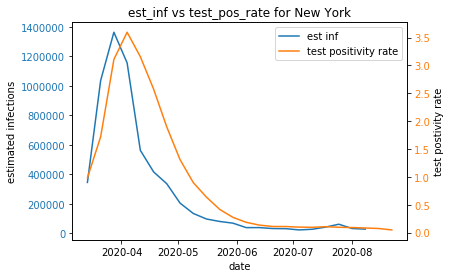

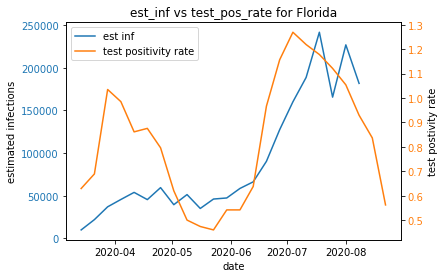

In [1841]:
# set months to use to make sure dates in the graphs don't overlap (formatting issue)
months = mdates.MonthLocator()

# set format for x-axis
fmt = mdates.DateFormatter('%Y-%m')

color1 = 'tab:blue'
color2 = 'tab:orange'

# estimated infections vs. test positivity rate for state1
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting1['date'], for_plotting1['est_inf'], '-', label='est inf', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'est_inf vs test_pos_rate for {state1}')
ax.set_xlabel('date')
ax.set_ylabel('estimated infections')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()



# estimated infections vs. test positivity rate for state2
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting2['date'], for_plotting2['est_inf'], '-', label='est inf', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'est_inf vs test_pos_rate for {state2}')
ax.set_xlabel('date')
ax.set_ylabel('estimated infections')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()

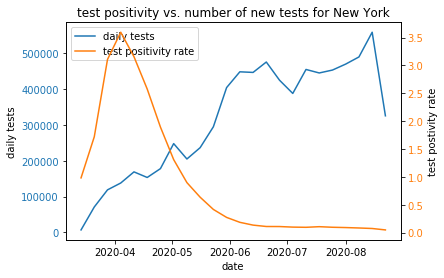

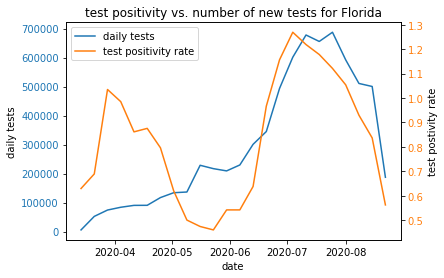

In [1842]:
#### these figures show the correlation between the number of new tests administered weekly and the test positivity rate for those weeks

fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting1['date'], for_plotting1['new_results_reported'], '-', label='daily tests', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'test positivity vs. number of new tests for {state1}')
ax.set_xlabel('date')
ax.set_ylabel('daily tests')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(for_plotting2['date'], for_plotting2['new_results_reported'], '-', label='daily tests', color=color1)
ax2 = ax.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['test_positivity_rate'], label='test positivity rate', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')

ax.set_title(f'test positivity vs. number of new tests for {state2}')
ax.set_xlabel('date')
ax.set_ylabel('daily tests')
ax.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('test postivity rate')
ax2.tick_params(axis='y', labelcolor=color2)

ax.xaxis.set_major_locator(months)
ax.format_xdata = fmt 

plt.show()

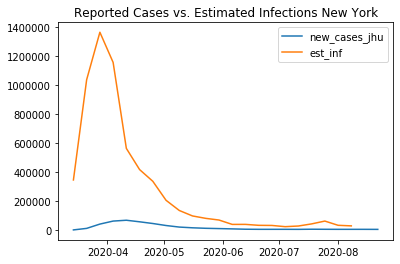

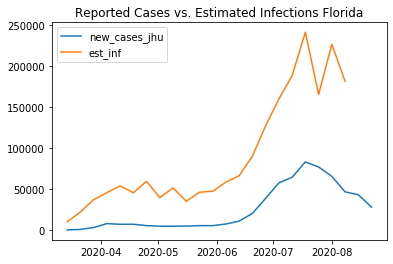

In [1843]:

plt.plot('date', 'new_cases_jhu', data = for_plotting1, label='new_cases_jhu')
plt.plot('date', 'est_inf', data = for_plotting1, label='est_inf')
plt.legend(loc="best")
X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Reported Cases vs. Estimated Infections {state1}')
plt.show()


plt.plot('date', 'new_cases_jhu', data = for_plotting2, label='new_cases_jhu')
plt.plot('date', 'est_inf', data = for_plotting2, label='est_inf')
plt.legend(loc="best")
X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Reported Cases vs. Estimated Infections {state2}')
plt.show()
plt.show()

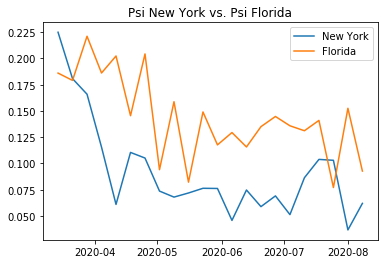

In [1844]:
plt.plot('date', 'psi', data = for_plotting1, label=state1)
plt.plot('date', 'psi', data = for_plotting2, label=state2)
plt.legend(loc="upper right")
X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Psi {state1} vs. Psi {state2}')
plt.show()

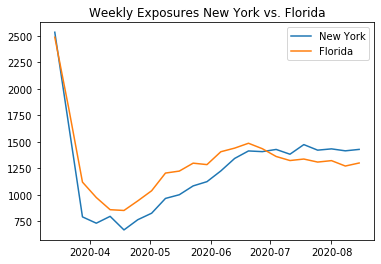

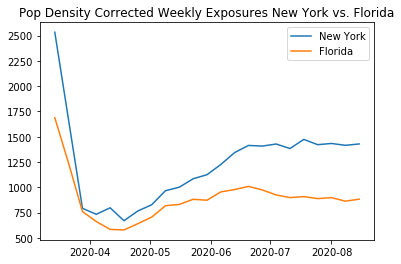

In [1845]:
plt.plot('date', 'weekly_expousres', data = for_plotting1, label=state1)
plt.plot('date', 'weekly_expousres', data = for_plotting2, label=state2)
plt.legend(loc="best")

X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Weekly Exposures {state1} vs. {state2}')
plt.show()


plt.plot('date', 'density_cor_expousre', data = for_plotting1, label=state1)
plt.plot('date', 'density_cor_expousre', data = for_plotting2, label=state2)
plt.legend(loc="best")

X = plt.gca().xaxis
X.set_major_locator(months)
# Specify formatter
X.set_major_formatter(fmt)
plt.title(f'Pop Density Corrected Weekly Exposures {state1} vs. {state2}')

plt.show()

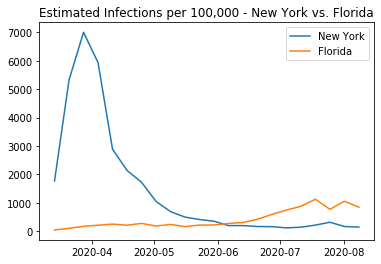

In [1846]:
plt.plot('date', 'est_inf_per_100k', data = for_plotting1, label=state1)
plt.plot('date', 'est_inf_per_100k', data = for_plotting2, label=state2)
plt.legend(loc="best")

X = plt.gca().xaxis
X.set_major_locator(months)
X.set_major_formatter(fmt)
plt.title(f'Estimated Infections per 100,000 - {state1} vs. {state2}')
plt.show()

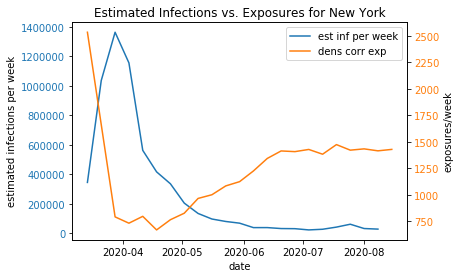

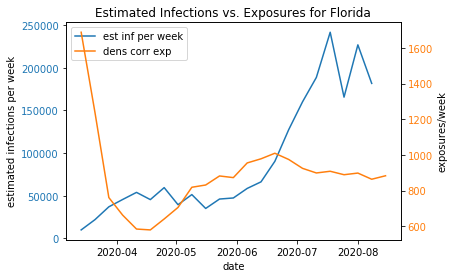

In [1847]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting1['date'], for_plotting1['est_inf'], '-', label='est inf per week', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections per week')
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('exposures/week')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt

plt.title(f'Estimated Infections vs. Exposures for {state1}')
plt.show()


fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting2['date'], for_plotting2['est_inf'], '-', label='est inf per week', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections per week')
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('exposures/week')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt

plt.title(f'Estimated Infections vs. Exposures for {state2}')
plt.show()

New York


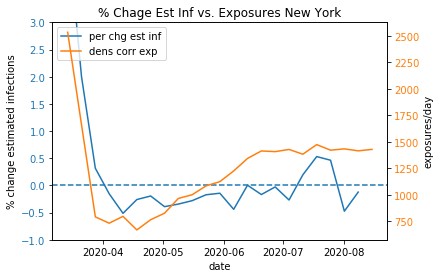

Florida


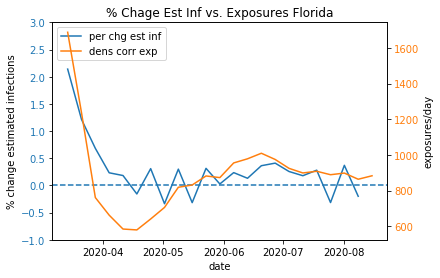

In [1848]:
# for_plotting1 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state1) & (weekly_est_cases_deaths['date'] > '2020-04-07')]
# for_plotting2 = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == state2) & (weekly_est_cases_deaths['date'] > '2020-04-07')]

print(state1)
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting1['date'], for_plotting1['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('% change estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-1,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. Exposures {state1}')
plt.show()

print(state2)
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting2['date'], for_plotting2['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['density_cor_expousre'], label='dens corr exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('% change estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-1,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. Exposures {state2}')
plt.show()

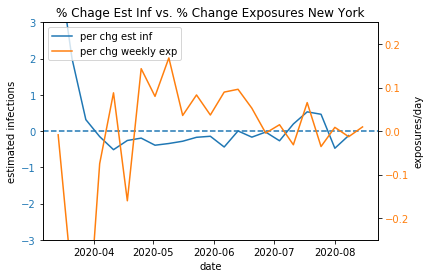

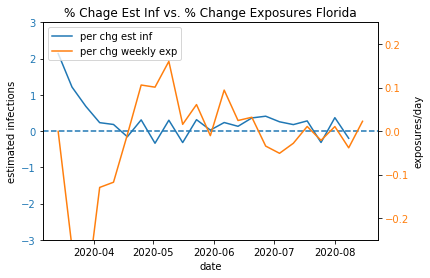

In [1849]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting1['date'], for_plotting1['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting1['date'], for_plotting1['pro_chg_weekly_expousres'], label='per chg weekly exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-3,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([-0.25,0.25])

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. % Change Exposures {state1}')
plt.show()


fig = plt.figure()
ax1 = fig.add_subplot(111)

lns1 = ax1.plot(for_plotting2['date'], for_plotting2['pro_chg_est_inf'], '-', label='per chg est inf', color=color1)
ax2 = ax1.twinx()
lns2 = ax2.plot(for_plotting2['date'], for_plotting2['pro_chg_weekly_expousres'], label='per chg weekly exp', color=color2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_locator(months)
ax1.format_xdata = fmt
ax1.set_ylim([-3,3])

ax2.set_ylabel('exposures/day')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([-0.25,0.25])

ax1.axhline(y=0.0, color=color1, linestyle='--')
plt.title(f'% Chage Est Inf vs. % Change Exposures {state2}')
plt.show()